<a href="https://colab.research.google.com/github/Carabinero/politeness-review-classification/blob/main/politeness_convencional_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install sklearn.ensemble

ERROR: Could not find a version that satisfies the requirement sklearn.ensemble (from versions: none)
ERROR: No matching distribution found for sklearn.ensemble


## 1. Definição do Problema

Trata-se do problema de classificar o tom de polidez de revisões de artigos.
O dataset possui 2500 instancias classificadas em 5 niveis de polidez mutuamente excludente (cada amostra pertence a apenas uma classe).

### 1.1 Carregamento das bibliotecas

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from string import punctuation
import re
from transformers import pipeline, AutoTokenizer, AutoModel
from gensim import utils
import gensim.models
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from functools import reduce
from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer,
)
from wordcloud import WordCloud
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
# from sklearn.ensemble import MetaEstimator




## 2. Preparação dos Dados
Análise e pré-processamento:

Verifique se os dados estão balanceados entre as classes. Se houver desbalanceamento, considere técnicas como oversampling (SMOTE) ou undersampling.
- Normalização ou padronização dos atributos numéricos.
- Codificação de atributos categóricos (e.g., one-hot encoding, label encoding).

Divisão dos Dados:

- Divida o conjunto de dados em treino, validação e teste (e.g., 70% treino, 15% validação, 15% teste).
Codificação das Classes:

- Use label encoding para multi-classe.
- Para multi-label, utilize multi-hot encoding.


### 2.1 Carregamento dos dados e limpeza inicial

In [5]:
df = pd.read_csv('sample_data/PolitenessDataset-FULL.csv')
print(df.shape)
df.drop(['Review ID', 'Venue', 'Review URL'], axis=1, inplace=True)
df.dropna(inplace=True)
df

(2500, 5)


,review,Tone
0,"It is early in the year, but difficult to imag...",2
1,You do not use the empirical data for the anal...,2
2,I understand that Wikipedia is not the best so...,3
3,Reviewer #1: 'The project can hardly be descri...,3
4,The figures are dishonest and not all that use...,2
...,...,...
2495,The scientific contribution of this paper - if...,2
2496,Reviewer 2: The proposal is also poorly writte...,2
2497,The paper could be considered for acceptance g...,3
2498,I don't see how your approach has potential to...,2


In [6]:
def preprocess(x: str):
    new_x = x.replace(r'"',' ')
    for c in punctuation:
        new_x = new_x.replace(c,' ')
    pattern = r"""
    [^\w\s]|         # Remove punctuation
    http\S+|         # Remove links
    @\w+|            # Remove mentions
    #\S+|            # Remove hashtags
    \b\w*\d\w*\b|    # Remove words containing numbers
    \s+              # Normalize spaces
    """
    new_x = re.sub(pattern, ' ', new_x, flags=re.VERBOSE) #removendo pontuação do texto
    return new_x.lower().strip()

df['review_pro'] = df['review'].apply(preprocess)
df = df.drop(["review"], axis=1)
df = df.rename(columns={"review_pro": "review"})
df = df.rename(columns={"Tone": "tone"})
# print(df.columns)
df

,tone,review
0,2,it is early in the year but difficult to imagi...
1,2,you do not use the empirical data for the anal...
2,3,i understand that wikipedia is not the best so...
3,3,reviewer the project can hardly be described...
4,2,the figures are dishonest and not all that useful
...,...,...
2495,2,the scientific contribution of this paper if t...
2496,2,reviewer the proposal is also poorly written...
2497,3,the paper could be considered for acceptance g...
2498,2,i don t see how your approach has potential to...


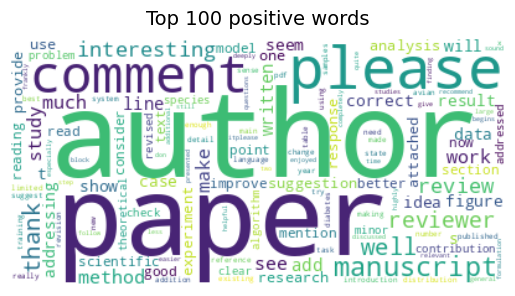

In [7]:
positive_df = df[df["tone"] == 5]["review"][:100]  # 1 = positive, 0 = negative
positive_df = reduce(lambda a, b: a + b, positive_df)

# Create and generate a word cloud image
cloud_positives = WordCloud(background_color="white").generate(positive_df)

# Display the generated wordcloud image
plt.imshow(cloud_positives, interpolation="bilinear")
plt.title("Top 100 positive words", y=1.02, size=14)  # Choose title, position and size
plt.axis("off")  # Turn off axis labels

# Show the final image
plt.show()

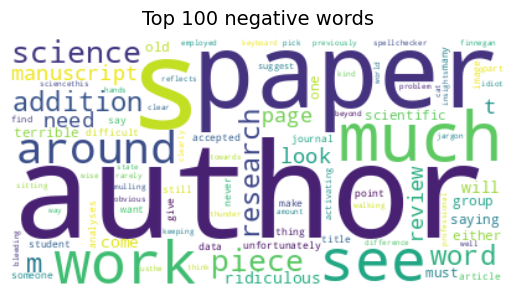

In [8]:
negative_df = df[df["tone"] == 1]["review"][:100]  # 1 = positive, 0 = negative
negative_df = reduce(lambda a, b: a + b, negative_df)

# Create and generate a word cloud image
cloud_positives = WordCloud(background_color="white").generate(negative_df)

# Display the generated wordcloud image
plt.imshow(cloud_positives, interpolation="bilinear")
plt.title("Top 100 negative words", y=1.02, size=14)  # Choose title, position and size
plt.axis("off")  # Turn off axis labels

# Show the final image
plt.show()

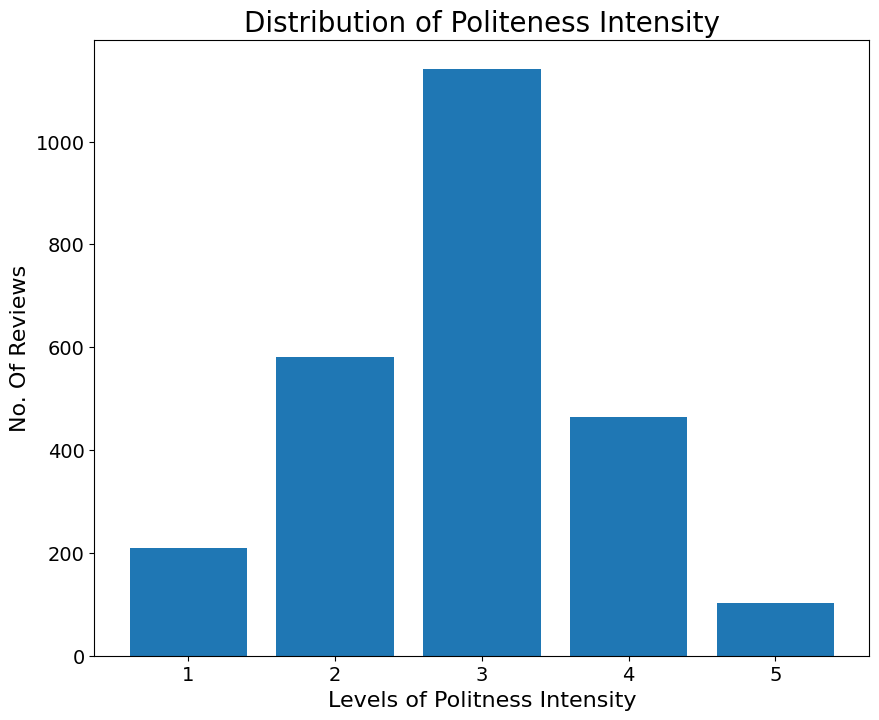

In [9]:
def plotClassDistri(df, cols):

    labels_val = dict(df[cols].value_counts())
    sorted_vals = [labels_val[key] for key in sorted(labels_val.keys())]

    fig, ax = plt.subplots(figsize=(10, 8))
    plt.bar( sorted(labels_val.keys()), sorted_vals)
    plt.title("Distribution of Politeness Intensity", fontsize=20)
    plt.xlabel("Levels of Politness Intensity",fontsize=16)
    plt.ylabel("No. Of Reviews", fontsize=16)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14, rotation=0)
    plt.show()


plotClassDistri(df,'tone')

In [10]:
df.tone.value_counts()

,count
tone,
3,1141
2,581
4,465
1,210
5,102


### 2.2 Tratando o desbalanceamento entre classes

In [11]:
def calcAvgSentLen():
    reviews = df.review.values
    len_arr = []
    for r in reviews:
        len_arr.append(len(r.split()) )

    print('\nAVG NO. OF WORDS : ',sum(len_arr)//len(len_arr))

calcAvgSentLen()


AVG NO. OF WORDS :  19


In [12]:
MAX_RECORDS_PER_CLASSS = df.tone.value_counts().max()
UNIQUE_CATEGORIES = df.tone.unique()

upsampled_df = pd.DataFrame(columns= df.columns)
for label in UNIQUE_CATEGORIES:
    df_class = df[df.tone == label]
    # print(label , ": ", df_class.shape)
    df_class = df_class.sample(MAX_RECORDS_PER_CLASSS , replace=True)
    print(label , " : ", df_class.shape)
    upsampled_df = pd.concat([upsampled_df, df_class], axis=0)

upsampled_df.reset_index(inplace=True)
upsampled_df.drop('index', axis=1, inplace=True)
print("\nFINAL UPSAMPLED DATAFRAME : " , upsampled_df.shape)

2  :  (1141, 2)
3  :  (1141, 2)
1  :  (1141, 2)
4  :  (1141, 2)
5  :  (1141, 2)

FINAL UPSAMPLED DATAFRAME :  (5705, 2)


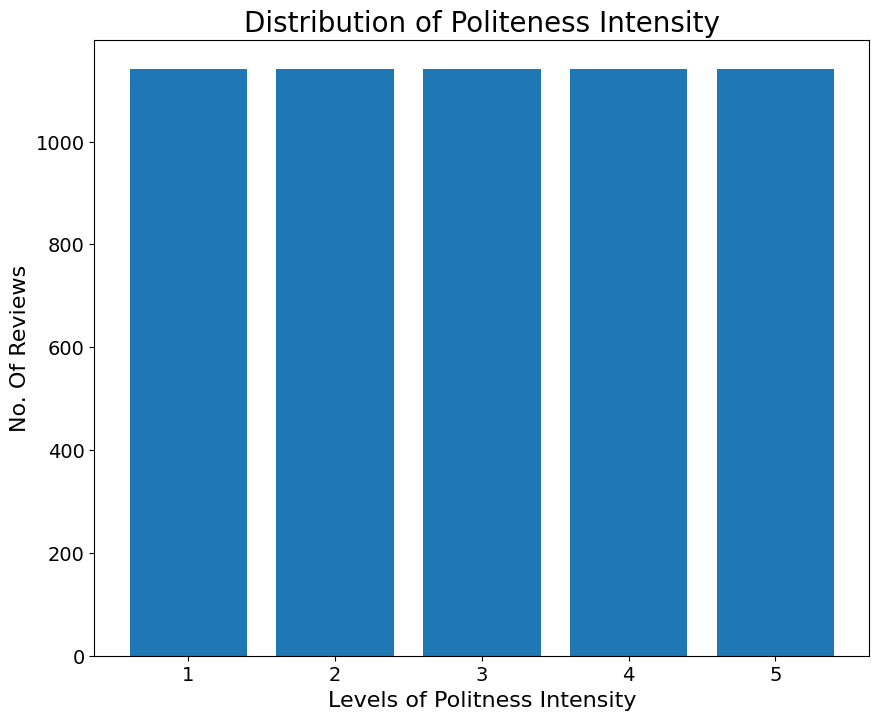

In [13]:
plotClassDistri(upsampled_df, 'tone')

### 2.3 One Hot Encoder

In [14]:
# Specify the columns you wish to one-hot encode
categorical_columns = [
    "tone"
]
upsampled_df.columns
# Perform the one-hot encoding
upsampled_df = pd.get_dummies(upsampled_df, columns=categorical_columns)

# View the resulting DataFrame
upsampled_df

,review,tone_1,tone_2,tone_3,tone_4,tone_5
0,why not do the study in vivo instead of in vitro,False,True,False,False,False
1,i do not trust the data or the underlying thesis,False,True,False,False,False
2,based on my understanding of fi lm at least th...,False,True,False,False,False
3,what do you mean by name of scientist s concep...,False,True,False,False,False
4,this lack of familiarity with the literature i...,False,True,False,False,False
...,...,...,...,...,...,...
5700,thank you for making the requested addition i ...,False,False,False,False,True
5701,thank you for your answer i have no comments t...,False,False,False,False,True
5702,thanks for addressing my concerns congrats on ...,False,False,False,False,True
5703,thanks for your rivision response paper accepted,False,False,False,False,True


### 2.4 Criando um vetorizador do texto

In [15]:
# Build the vectorizer
vect = TfidfVectorizer(
    stop_words='english',  # Default list of English stop words
    ngram_range=(1, 2),  # Consider Uni- and Bi-grams
    max_features=200,  # Max number of features
    token_pattern=r"\b[^\d\W][^\d\W]+\b",  # Capture only words using this pattern
)

vect.fit(upsampled_df.review)

# Create sparse matrix from the vectorizer
X = vect.transform(upsampled_df.review)

# Create a DataFrame
df_transformed = pd.DataFrame(data=X.toarray(), columns=vect.get_feature_names_out())
df_transformed

,abstract,accepted,actually,add,addition,additional,addressed,addressing,al,algorithm,...,unfortunately,use,used,useful,using,way,weak,work,writing,written
0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.495472,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5700,0.0,0.000000,0.0,0.000000,0.498287,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5701,0.0,0.000000,0.0,0.656866,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5702,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.654896,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.453181,0.0,0.0
5703,0.0,0.580339,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## 2.5 Separando dados de treinamento e teste

In [16]:
dropped = upsampled_df.drop(["review"], axis=1)
transformed = pd.concat([dropped, df_transformed], axis=1)
transformed


,tone_1,tone_2,tone_3,tone_4,tone_5,abstract,accepted,actually,add,addition,...,unfortunately,use,used,useful,using,way,weak,work,writing,written
0,False,True,False,False,False,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,False,True,False,False,False,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,False,True,False,False,False,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.495472,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,False,True,False,False,False,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,False,True,False,False,False,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5700,False,False,False,False,True,0.0,0.000000,0.0,0.000000,0.498287,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5701,False,False,False,False,True,0.0,0.000000,0.0,0.656866,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5702,False,False,False,False,True,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.453181,0.0,0.0
5703,False,False,False,False,True,0.0,0.580339,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [17]:
tone_cols = [col for col in transformed.columns if col.startswith("tone_")]
X = transformed.drop(columns=tone_cols, axis=1) # Drop columns starting with "tone_"
X

,abstract,accepted,actually,add,addition,additional,addressed,addressing,al,algorithm,...,unfortunately,use,used,useful,using,way,weak,work,writing,written
0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.495472,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5700,0.0,0.000000,0.0,0.000000,0.498287,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5701,0.0,0.000000,0.0,0.656866,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5702,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.654896,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.453181,0.0,0.0
5703,0.0,0.580339,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [18]:
y_5 = transformed["tone_5"].astype(int)
y_4 = transformed["tone_4"].astype(int)
y_3 = transformed["tone_3"].astype(int)
y_2 = transformed["tone_2"].astype(int)
y_1 = transformed["tone_1"].astype(int)


print(y_5.value_counts())
print(y_4.value_counts())
print(y_3.value_counts())
print(y_2.value_counts())
print(y_1.value_counts())

tone_5
0    4564
1    1141
Name: count, dtype: int64
tone_4
0    4564
1    1141
Name: count, dtype: int64
tone_3
0    4564
1    1141
Name: count, dtype: int64
tone_2
0    4564
1    1141
Name: count, dtype: int64
tone_1
0    4564
1    1141
Name: count, dtype: int64


In [19]:
# Train/test split
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(
    X,
    y_5,
    stratify=y_5,  # Stratify based on the target
    test_size=0.2,  # Set size of test_set
    random_state=456,  # Random seed for reproducibility
)

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(
    X,
    y_4,
    stratify=y_4,  # Stratify based on the target
    test_size=0.2,  # Set size of test_set
    random_state=456,  # Random seed for reproducibility
)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X,
    y_3,
    stratify=y_3,  # Stratify based on the target
    test_size=0.2,  # Set size of test_set
    random_state=456,  # Random seed for reproducibility
)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X,
    y_2,
    stratify=y_2,  # Stratify based on the target
    test_size=0.2,  # Set size of test_set
    random_state=456,  # Random seed for reproducibility
)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X,
    y_1,
    stratify=y_1,  # Stratify based on the target
    test_size=0.2,  # Set size of test_set
    random_state=456,  # Random seed for reproducibility
)




## 3. Escolha do Modelo
Selecione modelos que suportam classificação multi-classe diretamente, ou implemente estratégias para transformar o problema.

Modelos que Suportam Multi-Classe Diretamente:
- Árvores de Decisão (e.g., Random Forest, Gradient Boosting, XGBoost).
- Regressão Logística Multiclasse.
- Redes Neurais.
- K-Nearest Neighbors (kNN).
- Máquinas de Vetores de Suporte (SVM) com kernel apropriado.

Estratégias para Modelos que Não Suportam Multi-Classe Nativamente:
- One-vs-Rest (OvR):
 - Treina um modelo binário para cada classe, tratando-a como "positiva" e as outras como "negativas".
- One-vs-One (OvO):
 - Treina um modelo binário para cada par de classes e utiliza votação para decidir o rótulo final.

Essas estratégias são aplicáveis, por exemplo, para SVMs e modelos lineares.



### 3.1 Avaliação dos modelos

In [47]:
from collections import defaultdict

def train_and_evaluate_models(model_classes, X_train_data, X_test_data, y_train_data, y_test_data, tone_levels):
    """
    Trains specified models for each tone level and stores them in a dictionary.

    Args:
        model_classes: A list of model classes (e.g., [LogisticRegression, KNeighborsClassifier, GaussianNB]).
        X_train_data: A dictionary containing training data features for each tone level.
        X_test_data: A dictionary containing testing data features for each tone level.
        y_train_data: A dictionary containing training data labels for each tone level.
        y_test_data: A dictionary containing testing data labels for each tone level.
        tone_levels: A list of tone levels (e.g., [5, 4, 3, 2, 1]).

    Returns:
        A dictionary where keys are tone levels and values are dictionaries containing trained models.
    """
    trained_models = defaultdict(dict)  # Use defaultdict to store models for each tone level
    accuracy_results = defaultdict(dict)  # Store accuracy results

    for tone_level in tone_levels:
        for model_class in model_classes:
            # Create and train the model
            model = model_class.fit(X_train_data[tone_level], y_train_data[tone_level])

            # Predict the labels
            y_predicted = model.predict(X_test_data[tone_level])

            # # Print accuracy score and confusion matrix on test set
            # print(f"Accuracy on the test set (tone={tone_level}, model={model_class.__class__.__name__}): ", accuracy_score(y_test_data[tone_level], y_predicted))
            # print(confusion_matrix(y_test_data[tone_level], y_predicted) / len(y_test_data[tone_level]))

            # # Store the trained model in the dictionary
            # trained_models[tone_level][model_class.__class__.__name__] = model

            # Calculate and store accuracy
            accuracy = accuracy_score(y_test_data[tone_level], y_predicted)
            accuracy_results[model_class.__class__.__name__][tone_level] = accuracy

            # Store the trained model
            trained_models[tone_level][model_class.__class__.__name__] = model

    # Create and print the accuracy table
    accuracy_df = pd.DataFrame(accuracy_results).T  # Transpose for desired format
    accuracy_df.columns.name = "Tone Level" #set the name of the columns
    accuracy_df.index.name = "Model" #set the name of the lines
    print("\nAccuracy Table:")
    print(accuracy_df)

    return trained_models, accuracy_df

# Data dictionaries for training and testing data (assuming you have them defined)
X_train_data = {5: X_train_5, 4: X_train_4, 3: X_train_3, 2: X_train_2, 1: X_train_1}
X_test_data = {5: X_test_5, 4: X_test_4, 3: X_test_3, 2: X_test_2, 1: X_test_1}
y_train_data = {5: y_train_5, 4: y_train_4, 3: y_train_3, 2: y_train_2, 1: y_train_1}
y_test_data = {5: y_test_5, 4: y_test_4, 3: y_test_3, 2: y_test_2, 1: y_test_1}

# List of model classes
model_classes = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(n_neighbors=5),
    BernoulliNB(),
    MultinomialNB(),
    MLPClassifier(hidden_layer_sizes=(36, 12), random_state=42),
    RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=42),
    XGBClassifier()
]
# svm, random forest,

# List of tone levels
tone_levels = [5, 4, 3, 2, 1]

# Train and evaluate models
trained_models, accuracy_df = train_and_evaluate_models(model_classes, X_train_data, X_test_data, y_train_data, y_test_data, tone_levels)

# Accessing trained models
# Example: Accessing the LogisticRegression model for tone level 5
# log_reg_model_tone_5 = trained_models[5]['LogisticRegression']


Accuracy Table:
Tone Level                     5         4         3         2         1
Model                                                                   
LogisticRegression      0.895706  0.819457  0.809816  0.804557  0.827344
KNeighborsClassifier    0.975460  0.879930  0.836985  0.830850  0.867660
BernoulliNB             0.886941  0.804557  0.786152  0.789658  0.764242
MultinomialNB           0.869413  0.813322  0.803681  0.799299  0.822086
MLPClassifier           0.990359  0.951797  0.899211  0.901840  0.936897
RandomForestClassifier  0.993865  0.960561  0.897458  0.907099  0.943032
XGBClassifier           0.994741  0.916740  0.860649  0.859772  0.922875


In [48]:
accuracy_df['Average Accuracy'] = accuracy_df.mean(axis=1)
# print("\nAverage Accuracy per Model:")
# accuracy_table[['Average Accuracy']] #print a table with the average accuracy
accuracy_df

Tone Level,5,4,3,2,1,Average Accuracy
Model,,,,,,
LogisticRegression,0.895706,0.819457,0.809816,0.804557,0.827344,0.831376
KNeighborsClassifier,0.975460,0.879930,0.836985,0.830850,0.867660,0.878177
BernoulliNB,0.886941,0.804557,0.786152,0.789658,0.764242,0.806310
MultinomialNB,0.869413,0.813322,0.803681,0.799299,0.822086,0.821560
MLPClassifier,0.990359,0.951797,0.899211,0.901840,0.936897,0.936021
RandomForestClassifier,0.993865,0.960561,0.897458,0.907099,0.943032,0.940403
XGBClassifier,0.994741,0.916740,0.860649,0.859772,0.922875,0.910955


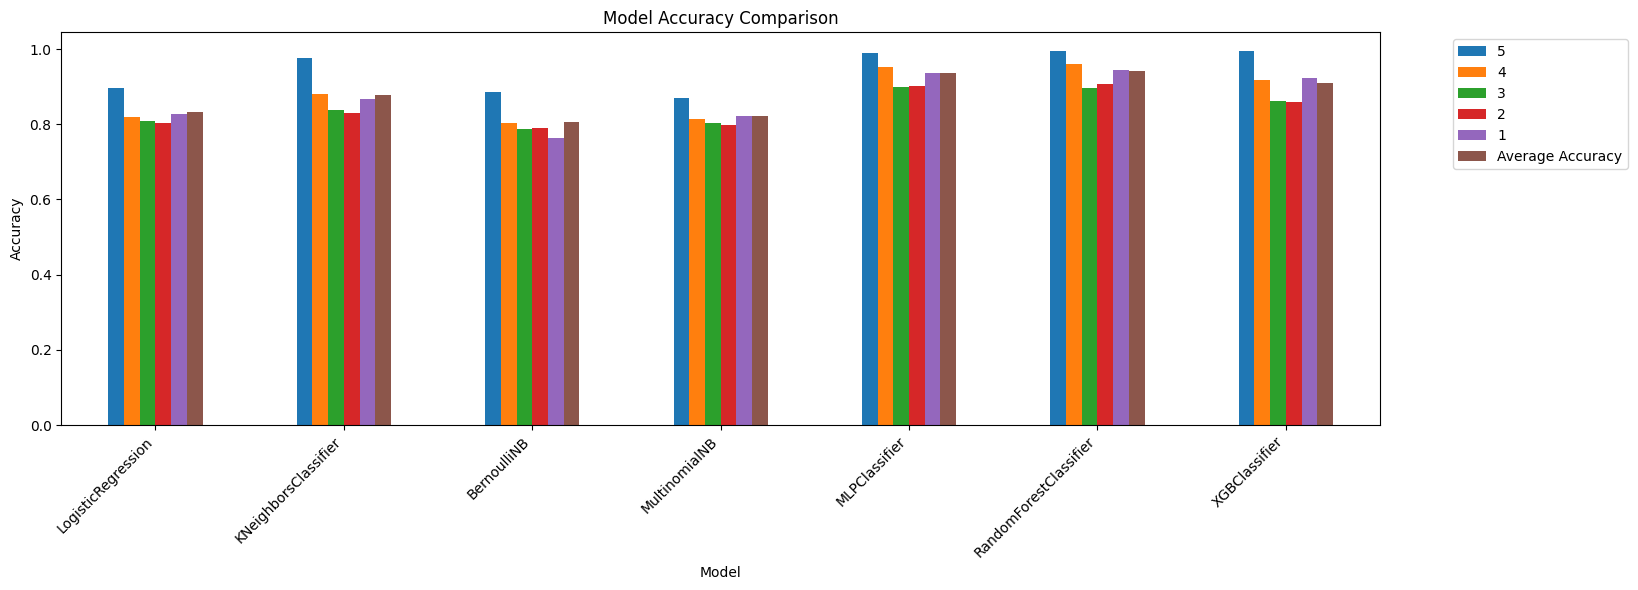

In [49]:
import matplotlib.pyplot as plt

ax = accuracy_df.plot(kind='bar', figsize=(14, 6))
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## 4. Treinamento do Modelo
Ajuste os hiperparâmetros usando validação cruzada ou conjuntos de validação.
Escolha uma função de perda adequada para multi-classe, como:
Cross-Entropy Loss (mais comum).
Categorical Hinge Loss.



## 5. Avaliação do Modelo
Use métricas apropriadas para problemas multi-classe:

Matriz de Confusão: Analisa erros entre as classes.
Acurácia: Percentual de previsões corretas.
F1-Score Macro: Média do F1-score entre classes (útil para dados desbalanceados).
AUC-ROC Multiclasse: Mede a qualidade do modelo em problemas de classificação probabilística.

In [ ]:
def shap_report(X, y):
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)

    train_X, val_X, train_y, val_y = train_test_split(X, y.values.ravel(), random_state=1)

    for a in range(len(models)):
        model = models[a]
        model_name = determine_model_name(model)

        model.fit(train_X, train_y)
        med = train_X.mean().values.reshape((1, train_X.shape[1]))

        # Create object that can calculate shap values
        explainer = shap.KernelExplainer(model.predict_proba, med)
        # Calculate Shap values
        shap_values = explainer.shap_values(val_X.iloc[0:len(train_X), :], nsamples=len(train_X))

        shap.summary_plot(shap_values[1], val_X.iloc[0:len(train_X), :], formatted_dictionary, show=False, color_bar=True,
                          max_display=10,
                          plot_size=(11, 8))

        plt.close()

def roc_curve_report(X, y):
    for a in range(len(models)):
        model = models[a]
        model_name = determine_model_name(model)
        try:
            tprs = []
            aucs = []
            mean_fpr = np.linspace(0, 1, 100)
            i = 0
            fig, ax = plt.subplots()
            for i, (train, test) in enumerate(cv.split(X, y)):
                model.fit(X[train], y[train])
                viz = plot_roc_curve(model, X[test], y[test],
                                     name='ROC fold {}'.format(i),
                                     alpha=0.3, lw=1, ax=ax)
                interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                aucs.append(viz.roc_auc)

            ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                    label='Chance', alpha=.8)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color='b',
                    label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                    lw=2, alpha=.8)

            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                            label=r'$\pm$ 1 std. dev.')

            ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
                   title=model_name)
            ax.legend(loc="lower right")
            plt.savefig(
                "../results/plots/test/roc_%s_%0i_features_%0i_test.pdf" % (
                    model_name, feature_size, len(X)),
                dpi=100, facecolor='w', edgecolor='b', orientation='portrait', transparent=False, bbox_inches=None,
                pad_inches=0.1)
            print("Created %s ROC figure" % model_name)
            plt.close()
        except (AttributeError, OverflowError) as detail:
            print(model_name + " Failed due to ", detail)